# **4. 프로젝트: CutMix 또는 Mixup 비교실험 하기**

## **0.필요한 라이브러리 불러오기**

In [2]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

### **우선 주요 라이브러리 버전을 확인**

In [3]:
import tensorflow as tf
import numpy as np

print(tf.__version__)
print(np.__version__)

2.8.0
1.21.5


### **GPU 환경을 확인**

In [4]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### **사용할 데이터셋 불러오기**  
stanford_dogs 데이터셋을 사용    
(120개 견종의 이미지가 포함, 총 20,580장의 이미지에서 12,000장은 학습셋, 나머지 8,580장은 평가용 데이터셋)

In [17]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

### **다운로드한 데이터를 확인**

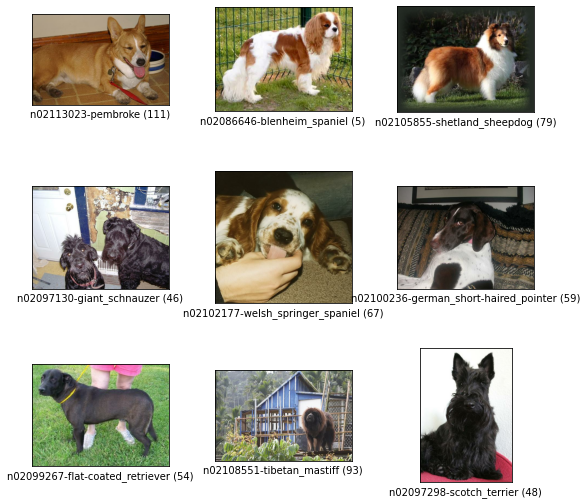

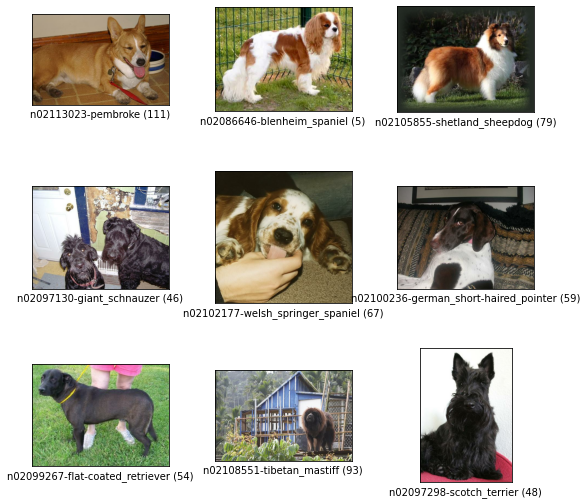

In [18]:
tfds.show_examples(ds_train, ds_info)

### **Augmentation 적용**

### **기본적인 전처리 함수를 만들어 주기**

In [19]:
def normalize_and_resize_img(image, label): # 변환할 이미지와 라벨, 
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

입력받은 이미지를 0~1 사이의 float32로 normalize하고, (224, 224) 사이즈로 resize  
이 함수는 훈련용과 테스트용으로 사용될 모든 이미지에 적용

In [20]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    return image, label

In [21]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [22]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

## **CutMix**

CutMix는 네이버 클로바(CLOVA)에서 발표한,  
CutMix: Regularization Strategy to Train Strong Classifiers with Localizable Features 에서 제안된 방법  
 Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법     
 CutMix는 이미지를 섞는 부분과 섞은 이미지에 맞추어 라벨을 섞는 부분을 포함

### **이미지 섞기**

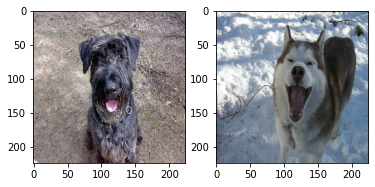

In [23]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

첫 번째 이미지 a를 바탕 이미지로 하고 거기에 삽입할 두 번째 이미지 b가 있을 때, a에 삽입될 영역의 바운딩 박스의 위치를 결정하는 함수를 먼저 구현

이번 노드에서는 이미지 a, b가 모두 (224, 224)로 resize되어 두 이미지의 width, height가 같은 경우로 가정할 수 있지만,
CutMix 공식 repo 에서는 width, height가 다르더라도 가변적으로 적용할 수 있도록 구현되어 있기 때문에,
임의의 이미지 사이즈에 대해서도 유연하게 대응 가능하도록 구현

In [24]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(137, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)
y :  tf.Tensor(117, shape=(), dtype=int32) tf.Tensor(224, shape=(), dtype=int32)


바탕이미지 image_a에서 바운딩 박스 바깥쪽 영역을, 다른 이미지 image_b에서 바운딩 박스 안쪽 영역을 가져와서 합치는 함수를 구현

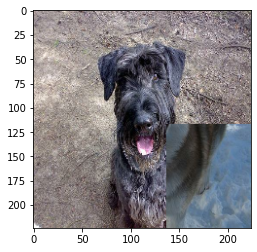

In [25]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

### **라벨 섞기**

이미지를 섞었다면 라벨도 이에 맞게 섞어주어야 한다.  
CutMix에서는 면적에 비례해서 라벨을 섞어준다.  
섞인 이미지의 전체 이미지 대비 비율을 계산해서 두 가지 라벨의 비율로 더해준다.  

In [26]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.81447303, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

위에서 구현한 두 함수 mix_2_images()와 mix_2_label()을 활용하여 배치 단위의 cutmix() 함수를 구현

In [27]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### **Mixup Augmentation**

두 개 이미지의 픽셀별 값을 비율에 따라 섞어주는 방식   
두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑고, 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어준다.

In [28]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.18644226 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.81355774 

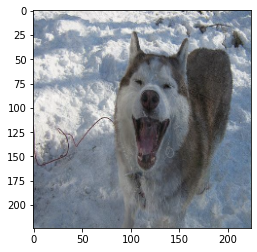

In [29]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    a = tf.random.uniform([],0,1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-a)*image_a + a*image_b
    mixed_label = (1-a)*label_a + a*label_b
    
    return mixed_image, mixed_label

mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img.numpy())
print(mixed_label)

위에서 구현한 함수를 활용하여 배치 단위의 mixup() 함수를 구현

In [30]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# **1. Augmentation을 적용한 데이터셋 만들기**

In [31]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [33]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False,with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )
    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

batch() 함수 뒤에 CutMix가 오도록 만들어야 하는 이유는  
CutMix는 배치 안에 있는 이미지끼리만 섞는 과정이기 때문에, 미리 배치 단위로 데이터셋을 정렬 후 CutMix가 적용되어야 한다. 

In [34]:
# augmentation이 적용된 데이터셋과 적용되지 않은 데이터셋 생성
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test = True)

# **2. 모델 만들기**

In [35]:
num_classes = ds_info.features["label"].num_classes
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False, # fully connected layer를 포함하지 않음
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

94781440/94765736 [==============================] - 1s 0us/step


In [36]:
resnet50_aug = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

In [37]:
resnet50_cutmix = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

In [38]:
resnet50_mixup = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224, 224, 3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation = 'softmax')
])

# **3. 모델 훈련하기**

 cutmix(), mixup()을 구현하면서 label의 mix 때문에 더이상 label이 스칼라값을 가지지 못하고 One-Hot 벡터 형태로 변환되었으므로,
 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용

In [39]:
#EPOCH = 20  # Augentation 적용 효과를 확인하기 위해 필요한 epoch 수
EPOCH = 20

tf.random.set_seed(2021)
resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_aug.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_cutmix.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

resnet50_mixup.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [40]:
history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 102s 117ms/step - loss: 2.2140 - accuracy: 0.4428 - val_loss: 3.1784 - val_accuracy: 0.2322
Epoch 2/20
750/750 [==============================] - 87s 116ms/step - loss: 0.7580 - accuracy: 0.7879 - val_loss: 1.1935 - val_accuracy: 0.6576
Epoch 3/20
750/750 [==============================] - 87s 115ms/step - loss: 0.2247 - accuracy: 0.9532 - val_loss: 0.9465 - val_accuracy: 0.7226
Epoch 4/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0964 - accuracy: 0.9883 - val_loss: 0.9071 - val_accuracy: 0.7428
Epoch 5/20
750/750 [==============================] - 88s 117ms/step - loss: 0.0425 - accuracy: 0.9967 - val_loss: 0.9086 - val_accuracy: 0.7441
Epoch 6/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0161 - accuracy: 0.9995 - val_loss: 0.9111 - val_accuracy: 0.7449
Epoch 7/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0093 - accuracy: 1.0000 - val_loss: 0.9197 - val_a

In [41]:
history_resnet50_aug = resnet50_aug.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 89s 115ms/step - loss: 0.0028 - accuracy: 0.9999 - val_loss: 1.0511 - val_accuracy: 0.7348
Epoch 2/20
750/750 [==============================] - 86s 115ms/step - loss: 0.0175 - accuracy: 0.9975 - val_loss: 1.0728 - val_accuracy: 0.7283
Epoch 3/20
750/750 [==============================] - 86s 115ms/step - loss: 0.0074 - accuracy: 0.9992 - val_loss: 1.0321 - val_accuracy: 0.7353
Epoch 4/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0039 - accuracy: 0.9996 - val_loss: 1.0164 - val_accuracy: 0.7422
Epoch 5/20
750/750 [==============================] - 86s 115ms/step - loss: 0.0035 - accuracy: 0.9998 - val_loss: 1.0392 - val_accuracy: 0.7345
Epoch 6/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0089 - accuracy: 0.9997 - val_loss: 1.0413 - val_accuracy: 0.7369
Epoch 7/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0035 - accuracy: 0.9997 - val_loss: 1.0198 - val_ac

In [42]:
history_resnet50_cutmix = resnet50_cutmix.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 98s 123ms/step - loss: 2.2261 - accuracy: 0.4447 - val_loss: 3.4803 - val_accuracy: 0.1867
Epoch 2/20
750/750 [==============================] - 86s 115ms/step - loss: 0.6606 - accuracy: 0.8167 - val_loss: 1.0148 - val_accuracy: 0.6981
Epoch 3/20
750/750 [==============================] - 86s 115ms/step - loss: 0.1780 - accuracy: 0.9667 - val_loss: 0.9009 - val_accuracy: 0.7298
Epoch 4/20
750/750 [==============================] - 86s 115ms/step - loss: 0.0475 - accuracy: 0.9971 - val_loss: 0.8880 - val_accuracy: 0.7423
Epoch 5/20
750/750 [==============================] - 86s 115ms/step - loss: 0.0200 - accuracy: 0.9999 - val_loss: 0.8931 - val_accuracy: 0.7467
Epoch 6/20
750/750 [==============================] - 87s 115ms/step - loss: 0.0127 - accuracy: 1.0000 - val_loss: 0.9095 - val_accuracy: 0.7422
Epoch 7/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0095 - accuracy: 1.0000 - val_loss: 0.9152 - val_ac

In [43]:
history_resnet50_mixup = resnet50_mixup.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 93s 116ms/step - loss: 2.1977 - accuracy: 0.4443 - val_loss: 3.3997 - val_accuracy: 0.2099
Epoch 2/20
750/750 [==============================] - 86s 115ms/step - loss: 0.6780 - accuracy: 0.8183 - val_loss: 1.1284 - val_accuracy: 0.6712
Epoch 3/20
750/750 [==============================] - 86s 115ms/step - loss: 0.1897 - accuracy: 0.9646 - val_loss: 0.9364 - val_accuracy: 0.7247
Epoch 4/20
750/750 [==============================] - 86s 115ms/step - loss: 0.0487 - accuracy: 0.9973 - val_loss: 0.8956 - val_accuracy: 0.7439
Epoch 5/20
750/750 [==============================] - 87s 115ms/step - loss: 0.0205 - accuracy: 0.9998 - val_loss: 0.9083 - val_accuracy: 0.7448
Epoch 6/20
750/750 [==============================] - 91s 122ms/step - loss: 0.0129 - accuracy: 0.9999 - val_loss: 0.9267 - val_accuracy: 0.7430
Epoch 7/20
750/750 [==============================] - 87s 116ms/step - loss: 0.0097 - accuracy: 1.0000 - val_loss: 0.9339 - val_ac

# **4. 훈련 과정 시각화하기**

NameError: ignored

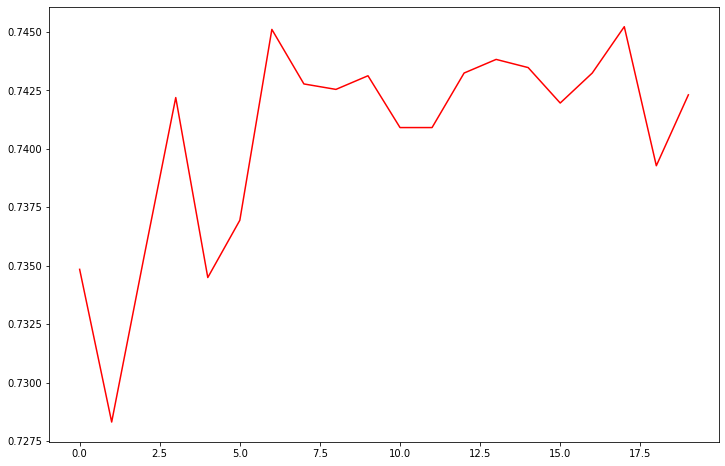

In [44]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation', 'With CutMix', 'With Mixup'], loc='upper left')
plt.grid(True)
plt.show()

조금 더 확대해 살펴보면

NameError: ignored

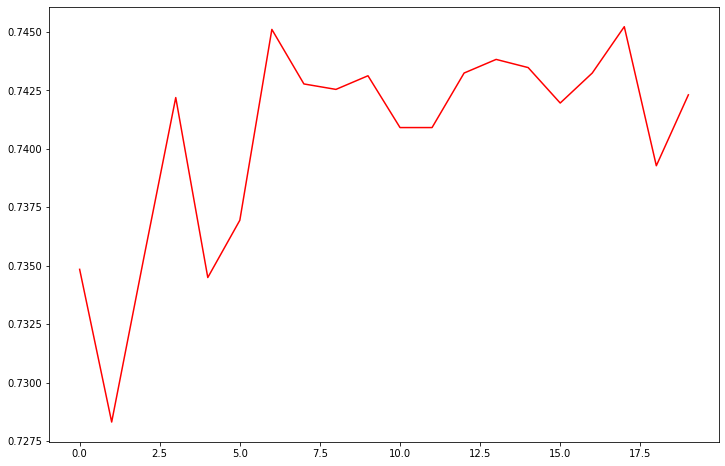

In [45]:
plt.figure(figsize=(12, 8))
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'r')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'k')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'With Augmentation'], loc='upper left')
plt.grid(True)
plt.ylim(0.50, 0.80)    # 출력하고자 하는  Accuracy 범위를 지정해 주세요. 
#plt.ylim(0.72, 0.76)  # EPOCH=20으로 진행한다면 이 범위가 적당합니다. 
plt.show()

## **5. Augmentation에 의한 모델 성능 비교**

In [46]:
import pandas as pd

acc_data = {'No Augmentation': history_resnet50_no_aug.history['val_accuracy'], 
            'With Augmentation': history_resnet50_aug.history['val_accuracy'], 
            'With CutMix': history_resnet50_cutmix.history['val_accuracy'], 
            'With Mixup': history_resnet50_mixup.history['val_accuracy']}
acc_df = pd.DataFrame(acc_data)
acc_df

NameError: ignored

In [47]:
acc_df.describe()

NameError: ignored

# **6. 회고**
history_resnet50_aug = resnet50_aug.fit 부분에서 오타가 나는 바람에 오류가 나고 말았다. 20에포크씩 4개를 하니 3시간 가량 걸렸는데, 다시 수정해서 돌릴 시간이 없어서 여기서 마무리 하게 되었다.
일단 제출하고 다시 수정해서 돌려보도록 하겠다.